In [ ]:
!pip install timm datasets torcheval diffusers

In [ ]:
!pip install k_diffusion

In [ ]:
import shutil,timm,os,torch,random,datasets,math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode
from glob import glob

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activation import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [ ]:
from fastprogress import progress_bar

In [ ]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus = 8

## Data processing

In [ ]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tiny-imagenet-200'

In [ ]:
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/tiny-imagenet-200.zip', 'data')

In [ ]:
bs = 512
xmean,xstd = tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615])

In [ ]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        '''
        Reads images & return normalised tensors
        '''
        img = read_image(self.files[i], mode=ImageReadMode.RGB)/255
        return (img - xmean[:,None,None])/xstd[:,None,None]

In [ ]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        # For classification
        # x,y = self.ds[i]
        # return self.tfmx(x), self.tfmy(y)

        # for img2img
        x = self.ds[i]
        return self.tfmx(x), self.tfmy(x)

In [ ]:
class TinyValDS(TinyDS):
    def __getitem__(self, i): return self.files[i],anno[os.path.basename(self.files[i])]

In [ ]:
def tfmx(x, size=64, augment=False):
    img = TF.rgb_to_grayscale(x, num_output_channels=3)
    transform_list = [
        T.RandomCrop(size),
        T.RandomHorizontalFlip(p=0.5),
    ]
    if augment:
      img = T.compose(transform_list)(img)
    return img

In [ ]:
def normalize(img):
    img_mean = xmean[:,None,None].to(def_device)
    img_std = xstd[:,None,None].to(def_device)
    return (img - img_mean)/img_std

In [ ]:
def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clip(0,1)

In [ ]:
tds = TinyDS(path/'train')
vds = TinyDS(path/'val')

tfm_tds = TfmDS(tds, tfmx)
tfm_vds = TfmDS(vds, tfmx)

dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

In [ ]:
xb,yb = next(iter(dls.train))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8df04a3490>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a8df04a3490>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    
Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7a8df04a3490>
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    Traceback (most recent call last):
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
self._shutdown_workers()
    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-pa

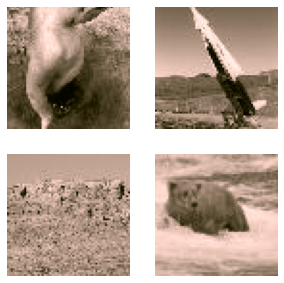

In [ ]:
show_images(denorm(xb[:4]), imsize=2.5);

## WandB

In [ ]:
!pip install wandb
import wandb

In [ ]:
class WandBCB(MetricsCB):
  order=100
  def __init__(self, config, *ms, project='colorize_image', **metrics):
    fc.store_attr()
    super().__init__(*ms, **metrics)

  def before_fit(self):
    wandb.init(project=self.project, config=self.config)
  def after_fit(self):
    wandb.finish()

  def _log(self, d):
    if self.learn.training:
      wandb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
    else:
      wandb.log({'val_'+m: float(d[m]) for m in self.all_metrics})
      wandb.log({'samples':self.sample_figure()})
    print(d)

  def sample_figure(self):
    with torch.no_grad():
      samples = denorm(colorize_img(tfmx(cx[104:120]), learner=self.learn))
    s = samples
    plt.clf()
    fig, axs = get_grid(16)
    for im,ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
    return fig

  def after_batch(self):
    super().after_batch()
    wandb.log({'loss':self.learn.loss})

## Unet

In [ ]:
def up_block(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                         ResBlock(ni, nf, ks=ks, act=act, norm=norm))

In [ ]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                for i in range(len(nfs)-1, 0, -1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])

In [ ]:
def zero_wgts(l):
    with torch.no_grad():
        l.weight.zero_()
        l.bias.zero_()

In [ ]:
def get_unet():
    model = TinyUnet()
    last_res = model.up[-1]
    zero_wgts(last_res.convs[-1][-1])
    zero_wgts(last_res.idconv[0])
    zero_wgts(model.end.convs[-1][-1])
    return model

## Training

In [ ]:
lr = 1e-3
epochs = 30
metrics = MetricsCB()
wandbcb = WandBCB(config={'lr':lr, 'epochs':epochs, 'comments':'default unet logging test'})
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision(), wandbcb]
lr_cbs = [DeviceCB(), ProgressCB()]
opt_func = partial(optim.AdamW, eps=1e-5)

In [ ]:
def colorize_img(img, learner=None, model=None):
    if learner: model = learner.model
    return model(img.to(def_device)).cpu()

In [ ]:
og_color_ds = TfmDS(vds)
og_dl = DataLoader(og_color_ds, batch_size=bs, shuffle=True, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
cx,cy = next(iter(og_dl))
cx = cx.to(def_device)

In [ ]:
print(timm.list_models('*vgg*'))

['repvgg_a0', 'repvgg_a1', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'repvgg_d2se', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [ ]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [ ]:
def calc_features(imgs, target_layers=(18,25)):
    x = normalize(imgs)
    feats = []
    for i,layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

In [ ]:
class PerceptualLoss():
    def __init__(self, target_layers=(18, 25)):
        fc.store_attr()
    def __call__(self, inp, targ):
        input_features = calc_features(inp, self.target_layers)
        target_features = calc_features(targ, self.target_layers)
        squared_error = sum((f1-f2).pow(2).mean()
                for f1,f2 in zip(input_features, target_features))
        return squared_error/len(input_features)

In [ ]:
perceptualLoss = PerceptualLoss(target_layers=(13,15,18,25,27))
def combined_loss(targ, inp):
    percept_loss = perceptualLoss(inp, targ)
    return percept_loss#F.mse_loss(inp, targ) #+ percept_loss/10

In [ ]:
clean_mem()

In [ ]:
# iw = partial(init_weights, leaky=0.1)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_unet(), dls, combined_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

/content/miniai/accel.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self): self.scaler = torch.cuda.amp.GradScaler()


loss,█▇█▇▇▇▆▆▇▆▆▆▆▆▆▆▅▅▅▄▄▄▅▄▄▄▄▃▃▂▃▂▂▂▁▁▂▁▂▁
train_loss,▁
val_loss,▁
loss,18.45399
train_loss,24.586
val_loss,18.613


loss,epoch,train
24.887,0,train
19.298,0,eval
17.906,1,train
17.551,1,eval
17.370,2,train
17.426,2,eval
17.133,3,train
17.238,3,eval
16.940,4,train
17.121,4,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


{'loss': '24.887', 'epoch': 0, 'train': 'train'}


<Figure size 420x280 with 0 Axes>

{'loss': '19.298', 'epoch': 0, 'train': 'eval'}
{'loss': '17.906', 'epoch': 1, 'train': 'train'}
{'loss': '17.551', 'epoch': 1, 'train': 'eval'}
{'loss': '17.370', 'epoch': 2, 'train': 'train'}
{'loss': '17.426', 'epoch': 2, 'train': 'eval'}
{'loss': '17.133', 'epoch': 3, 'train': 'train'}
{'loss': '17.238', 'epoch': 3, 'train': 'eval'}
{'loss': '16.940', 'epoch': 4, 'train': 'train'}
{'loss': '17.121', 'epoch': 4, 'train': 'eval'}
{'loss': '16.751', 'epoch': 5, 'train': 'train'}
{'loss': '16.983', 'epoch': 5, 'train': 'eval'}
{'loss': '16.566', 'epoch': 6, 'train': 'train'}
{'loss': '16.764', 'epoch': 6, 'train': 'eval'}
{'loss': '16.386', 'epoch': 7, 'train': 'train'}
{'loss': '16.661', 'epoch': 7, 'train': 'eval'}
{'loss': '16.176', 'epoch': 8, 'train': 'train'}
{'loss': '17.130', 'epoch': 8, 'train': 'eval'}
{'loss': '15.920', 'epoch': 9, 'train': 'train'}
{'loss': '16.445', 'epoch': 9, 'train': 'eval'}
{'loss': '15.652', 'epoch': 10, 'train': 'train'}
{'loss': '16.920', 'epoch': 1

/content/miniai/datasets.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)


{'loss': '16.845', 'epoch': 19, 'train': 'eval'}
{'loss': '10.368', 'epoch': 20, 'train': 'train'}
{'loss': '16.936', 'epoch': 20, 'train': 'eval'}
{'loss': '9.800', 'epoch': 21, 'train': 'train'}
{'loss': '16.741', 'epoch': 21, 'train': 'eval'}
{'loss': '9.290', 'epoch': 22, 'train': 'train'}
{'loss': '16.987', 'epoch': 22, 'train': 'eval'}


KeyboardInterrupt: 

<Figure size 420x280 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

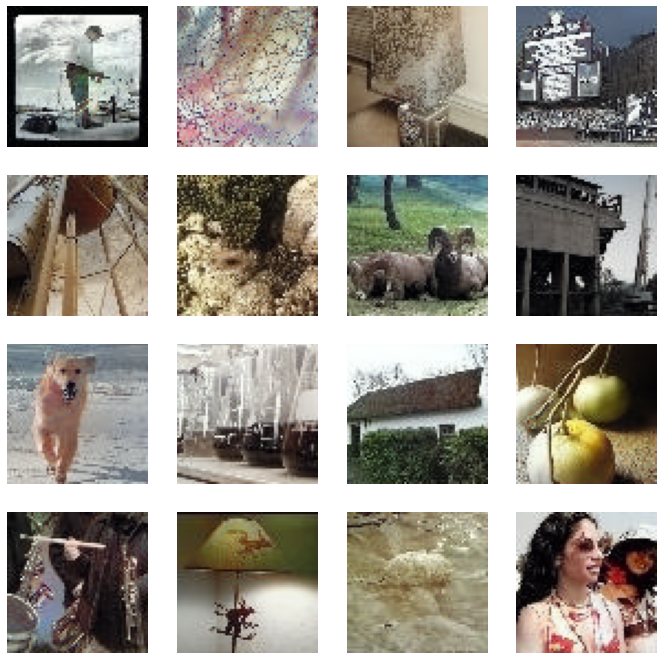

In [ ]:
learn.fit(epochs)

/content/miniai/accel.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self): self.scaler = torch.cuda.amp.GradScaler()


loss,epoch,train
14.541,0,train
15.054,0,eval
14.762,1,train
15.004,1,eval
14.505,2,train
15.026,2,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


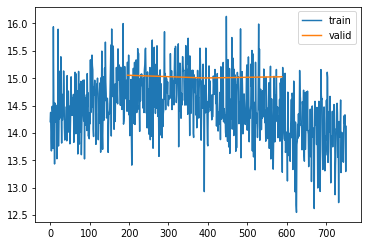

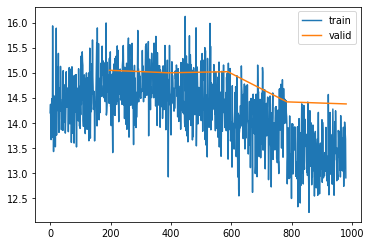

loss,epoch,train
14.541,0,train
15.054,0,eval
14.762,1,train
15.004,1,eval
14.505,2,train
15.026,2,eval
14.018,3,train
14.424,3,eval
13.417,4,train
14.383,4,eval


In [ ]:
learn.fit(epochs)

## Inference

In [ ]:
torch.save(learn.model, 'models/unet_colorize_precept_loss.pkl')

In [ ]:
model = torch.load('models/unet_colorize_precept_loss.pkl')

<ipython-input-60-882a62129621>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/unet_colorize_precept_loss.pkl')


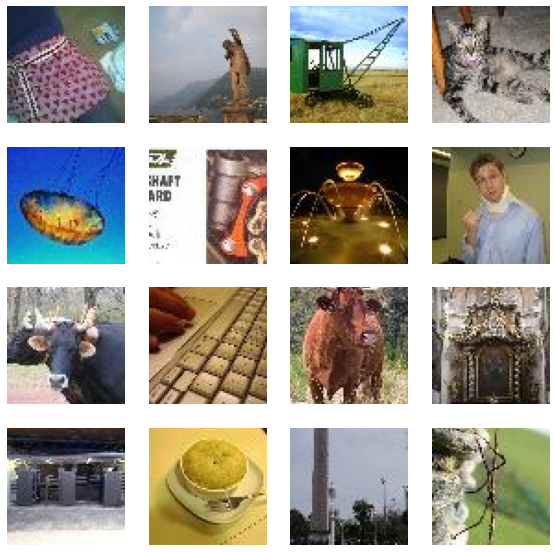

In [ ]:
show_images(denorm(cx[120:136].cpu()), imsize=2.5)

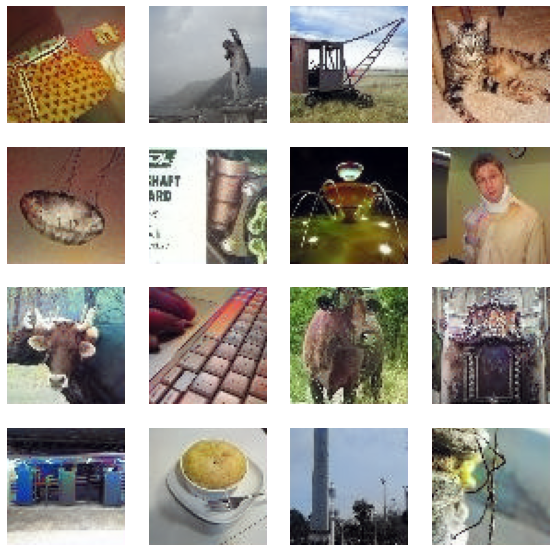

In [ ]:
img_test = colorize_img(tfmx(cx[120:136]), model=model)
show_images(denorm(img_test), imsize=2.5)

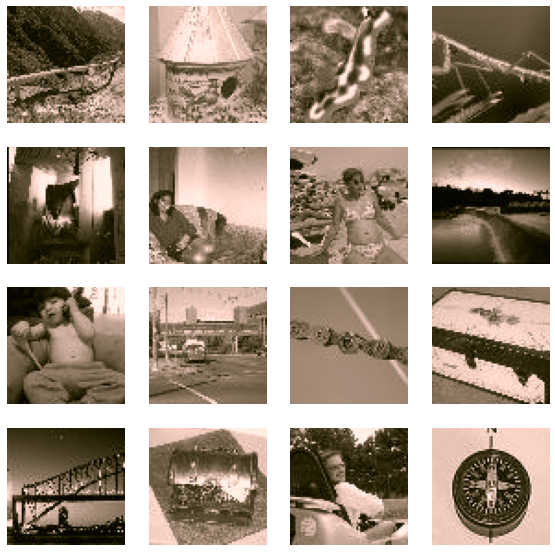

In [ ]:
show_images(denorm(tfmx(cx[120:136].cpu())), imsize=2.5)